# CLS Spontaneous Analysis

## Premade Analysis

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


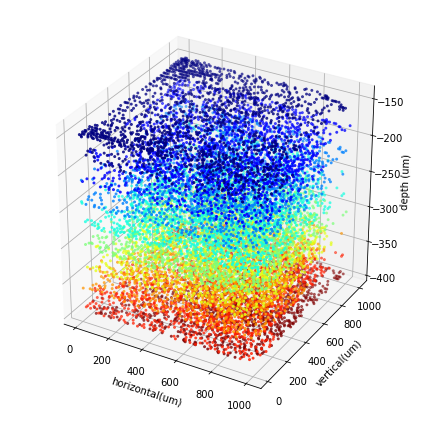

In [4]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

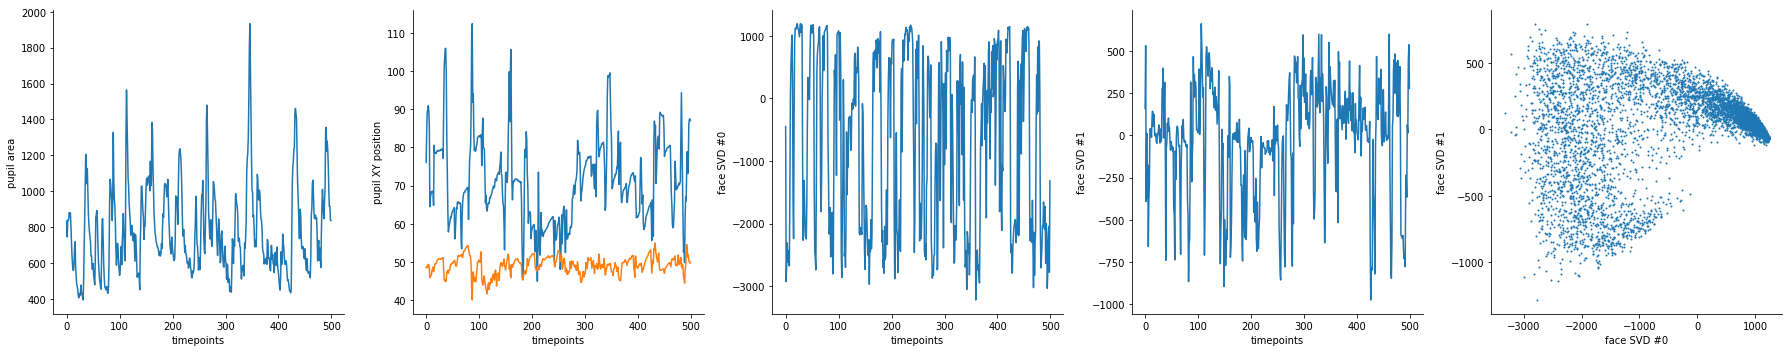

In [5]:
#@title Basic properties of behavioral data using plot and scatter
plt.figure(figsize=(25,5))
ax = plt.subplot(1,5,1)
plt.plot(dat['pupilArea'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(1,5,2)
plt.plot(dat['pupilCOM'][:500,:])
ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

ax = plt.subplot(1,5,3)
plt.plot(dat['beh_svd_time'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

ax = plt.subplot(1,5,4)
plt.plot(dat['beh_svd_time'][:500,1])
ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

ax = plt.subplot(1,5,5)
plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

plt.show()

/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


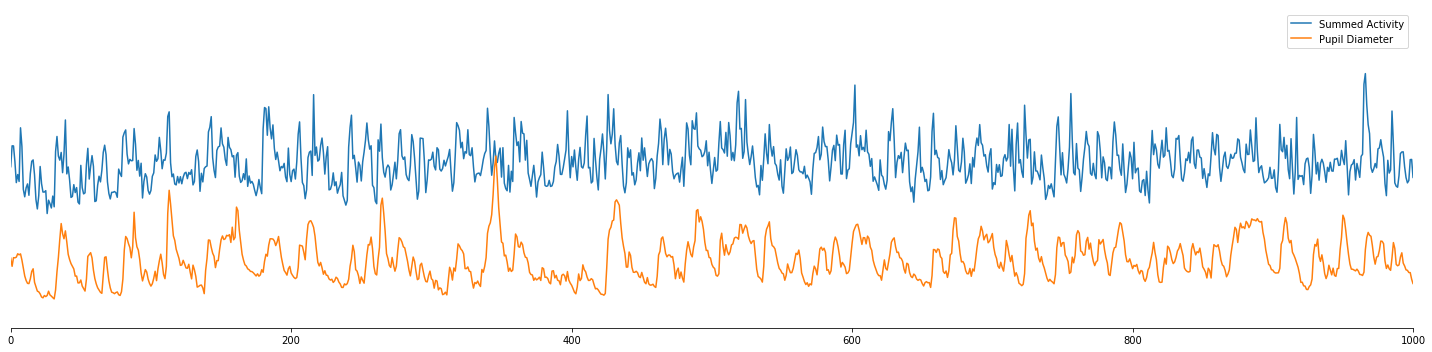

In [6]:
from scipy import stats
sum_activity = np.sum(dat['sresp'], axis=0)
plt.figure(figsize=(20,5))
plt.plot(sum_activity, label='Summed Activity')
plt.plot(dat['pupilArea'][:,0]*250, label='Pupil Diameter')
plt.xlim(0,1000)
plt.gca().yaxis.set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.legend()

In [7]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

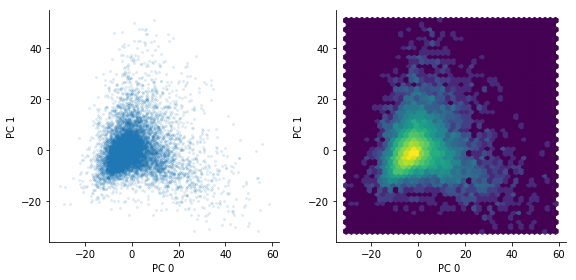

In [15]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin!
plt.figure(figsize=(20,4))
ax = plt.subplot(1,5,1)
plt.scatter(X[:,0], X[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(X[:,0], X[:,1], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [17]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
%pip install umap-learn
from umap import UMAP
ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 20, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)
             

    100% |################################| 71kB 4.2MB/s ta 0:00:011
    100% |################################| 2.6MB 466kB/s eta 0:00:01
    100% |################################| 13.5MB 126kB/s eta 0:00:01
    100% |################################| 25.9MB 69kB/s  eta 0:00:01    61% |###################             | 15.8MB 39.9MB/s eta 0:00:01    68% |######################          | 17.8MB 35.5MB/s eta 0:00:01
    100% |################################| 18.3MB 91kB/s  eta 0:00:01    90% |############################    | 16.5MB 43.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for umap-learn ... done
  Stored in directory: /root/.cache/pip/wheels/7d/1d/03/34aade9a9b97acddb8e93654eb856dadbf0964406eef8b96e2
Successfully built umap-learn
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Not removing or modifying (outside of prefix):
      /usr/bin/f2py3
      /usr/bin/f2py3.6
      Successfully uninstalled numpy-1.16.4
  Found existing installation:

In [18]:
from scipy.ndimage import uniform_filter1d
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis = 1)

/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


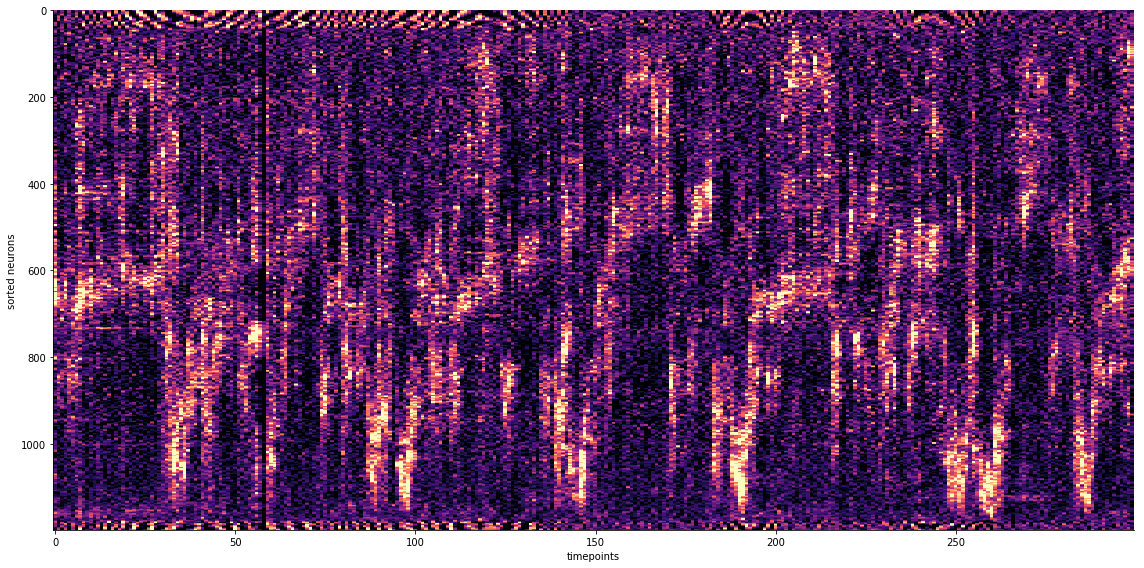

In [19]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

## Dimensionality Analysis



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [11]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from multiprocessing.dummy import Pool as ThreadPool

sns.set(style="white", palette="dark", color_codes=True)

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()

100%|██████████| 7/7 [3:22:09<00:00, 2786.00s/it]


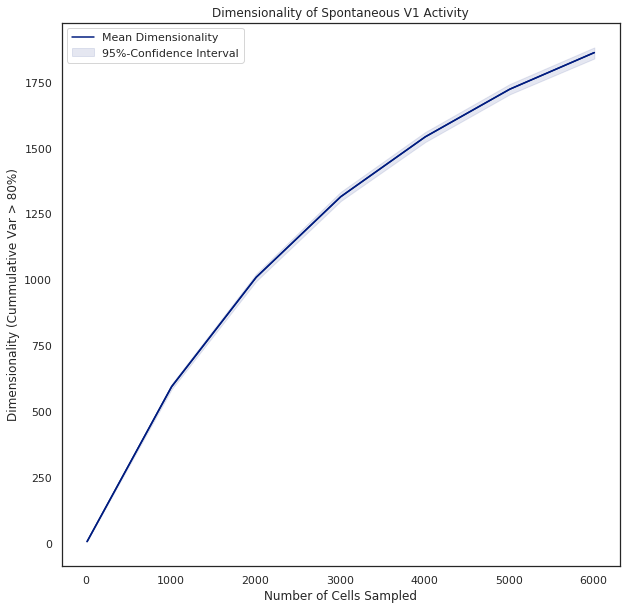

In [72]:
pca_rep_n = 100
cum_var_cutoff = 0.8
sample_nums = np.arange(10, 7010, 1000)

pca_lower_ci = []
pca_upper_ci = []
pca_mean = []

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

for sample_num in tqdm(sample_nums):
    dimensionality_dist = []
    for rep in range(pca_rep_n):
        cell_idx = np.random.choice(Z.shape[1], sample_num)
        data_pca = PCA(n_components = sample_num).fit(Z[:,cell_idx])
        cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
        dimensionality = np.where(cum_var_explained > cum_var_cutoff)[0][0]
        dimensionality_dist.append(dimensionality)
    pca_lower_ci.append(np.percentile(dimensionality_dist, 5))
    pca_upper_ci.append(np.percentile(dimensionality_dist, 95))
    pca_mean.append(np.mean(dimensionality_dist))

ax = plt.subplots(1,1,figsize=(10,10))[1]
ax.plot(sample_nums, pca_mean)
ax.fill_between(sample_nums, (pca_lower_ci), (pca_upper_ci), color='b', alpha=.1, label='95%-Confidence Interval')
plt.plot(sample_nums, pca_mean, color='b', label=f'Mean Dimensionality')
plt.xlabel('Number of Cells Sampled')
plt.ylabel(f'Dimensionality (Cummulative Var > {int(100*cum_var_cutoff)}%)')
plt.title('Dimensionality of Spontaneous V1 Activity')
plt.legend()
plt.show()
plt.close()

In [ ]:
pca_rep_n = 100
cum_var_cutoff = 0.8
sample_nums = np.arange(10, 7010, 1000)
np.random.shuffle(sample_nums)

pca_lower_ci = []
pca_upper_ci = []
pca_mean = []

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

for sample_num in tqdm(sample_nums):
    dimensionality_dist = []
    for rep in range(pca_rep_n):
        cell_idx = np.random.choice(Z.shape[1], sample_num)
        data_pca = PCA(n_components = sample_num).fit(Z[:,cell_idx])
        cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
        dimensionality = np.where(cum_var_explained > cum_var_cutoff)[0][0]
        dimensionality_dist.append(dimensionality)
    pca_lower_ci.append(np.percentile(dimensionality_dist, 5))
    pca_upper_ci.append(np.percentile(dimensionality_dist, 95))
    pca_mean.append(np.mean(dimensionality_dist))

sidx = np.argsort(sample_nums)
ax = plt.subplots(1,1,figsize=(10,10))[1]
ax.plot(sample_nums[sidx], pca_mean[sidx])
ax.fill_between(sample_nums[sidx], (pca_lower_ci[sidx]), (pca_upper_ci[sidx]), color='b', alpha=.1, label='95%-Confidence Interval')
plt.plot(sample_nums[sidx], pca_mean[sidx], color='b', label=f'Mean Dimensionality')
plt.xlabel('Number of Cells Sampled')
plt.ylabel(f'Dimensionality (Cummulative Var > {int(100*cum_var_cutoff)}%)')
plt.title('Dimensionality of Spontaneous V1 Activity')
plt.legend()
plt.show()
plt.close()

In [42]:
def get_pca_dimensionality(array):
    data_pca = PCA(n_components = array.shape[0]).fit(array)
    cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
    dimensionality = np.where(cum_var_explained > cum_var_cutoff)[0][0]
    return dimensionality

array_subset = []
for i in range(50):
    idx = np.random.choice(Z.shape[0], 1000)
    array_subset.append(np.copy(Z[idx]))

In [46]:
%%timeit
# Make the Pool of workers
pool = ThreadPool(2)
results = pool.map(get_pca_dimensionality, array_subset)
#close the pool and wait for the work to finish
pool.close()
pool.join()
print(results)

[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
2.26 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
# Make the Pool of workers
pool = ThreadPool(16)
results = pool.map(get_pca_dimensionality, array_subset)
#close the pool and wait for the work to finish
pool.close()
pool.join()
print(results)

[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]
2.03 s ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
len(array_subset)

16

In [ ]:
import numpy as np
import multiprocessing as mp
from . import galvo_corrections
import time

In [64]:
%%time
from multiprocessing import Pool, TimeoutError
import time
import os


pool = Pool(processes=2)              # start 4 worker processes

# print "[0, 1, 4,..., 81]"
print(pool.map(get_pca_dimensionality, array_subset))

[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]


In [63]:
asdf = [0.4, .8, 1]
np.random.choice(asdf, 10, p=asdf/np.sum(asdf))

array([1. , 0.4, 0.8, 1. , 0.8, 0.4, 1. , 1. , 0.8, 1. ])

In [65]:

from multiprocessing import Pool, TimeoutError
import time
import os


pool = Pool(processes=16)              # start 4 worker processes

# print "[0, 1, 4,..., 81]"
print(pool.map(get_pca_dimensionality, array_subset))

[141, 141, 141, 142, 142, 142, 141, 143, 141, 141, 142, 139, 141, 142, 142, 142]


In [47]:
import threading
import time

class myThread (threading.Thread):
   def __init__(self, threadID, name, counter, array):
      threading.Thread.__init__(self)
      self.threadID = threadID
      self.name = name
      self.counter = counter
      self.array = array
   def run(self):
      print ("Starting " + self.name)
      # Get lock to synchronize threads
      threadLock.acquire()
      print_time(self.name, self.counter, 3)
      # Free lock to release next thread
      threadLock.release()

def print_time(threadName, delay, counter):
   while counter:
      time.sleep(delay)
      print ("%s: %s" % (threadName, time.ctime(time.time())))
      counter -= 1

threadLock = threading.Lock()
threads = []

# Create new threads
thread1 = myThread(1, "Thread-1", 1)
thread2 = myThread(2, "Thread-2", 2)

# Start new Threads
thread1.start()
thread2.start()

# Add threads to thread list
threads.append(thread1)
threads.append(thread2)

# Wait for all threads to complete
for t in threads:
   t.join()
print ("Exiting Main Thread")

Starting Thread-1
Starting Thread-2
Thread-1: Tue Jul 21 03:00:39 2020
Thread-1: Tue Jul 21 03:00:40 2020
Thread-1: Tue Jul 21 03:00:41 2020
Thread-2: Tue Jul 21 03:00:43 2020
Thread-2: Tue Jul 21 03:00:45 2020
Thread-2: Tue Jul 21 03:00:47 2020
Exiting Main Thread


In [ ]:
pca_rep_n = 100
cum_var_cutoff = 0.8
sample_nums = np.arange(10, 1000, 100)

pca_lower_ci = []
pca_upper_ci = []
pca_mean = []

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

for sample_num in tqdm(sample_nums):
    dimensionality_dist = []
    for rep in range(pca_rep_n):
        cell_idx = np.random.choice(Z.shape[1], sample_num)
        data_pca = PCA(n_components = sample_num).fit(Z[cell_idx])
        cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
        dimensionality = np.where(cum_var_explained > cum_var_cutoff)[0][0]
        dimensionality_dist.append(dimensionality)
    pca_lower_ci.append(np.percentile(dimensionality_dist, 5))
    pca_upper_ci.append(np.percentile(dimensionality_dist, 95))
    pca_mean.append(np.mean(dimensionality_dist))

ax = plt.subplots(1,1,figsize=(10,10))[1]
ax.plot(sample_nums, pca_mean)
ax.fill_between(sample_nums, (pca_lower_ci), (pca_upper_ci), color='b', alpha=.1, label='95%-Confidence Interval')
plt.plot(sample_nums, pca_mean, color='b', label=f'Mean Dimensionality')
plt.xlabel('Number of Cells Sampled')
plt.ylabel(f'Dimensionality (Cummulative Var > {int(100*cum_var_cutoff)}%)')
plt.title('Dimensionality of Spontaneous V1 Activity')
plt.legend()
plt.show()
plt.close()


  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


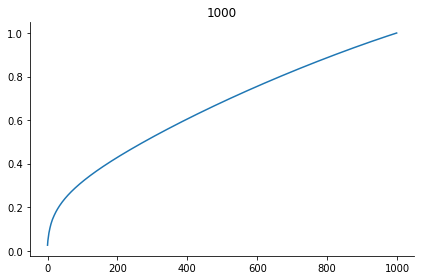


 50%|█████     | 1/2 [00:09<00:09,  9.62s/it]/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


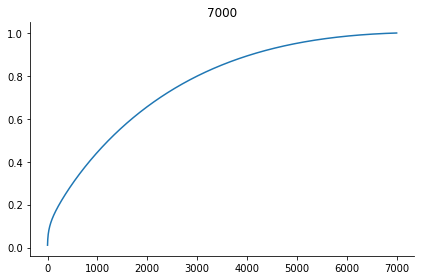


100%|██████████| 2/2 [01:39<00:00, 33.82s/it]

In [35]:
for ncomp in tqdm((1000, 7000)):
    Z = zscore(dat['sresp'], axis=1)
    Z = np.nan_to_num(Z)
    data_pca = PCA(n_components = ncomp).fit(Z)
    cum_var_explained = np.cumsum(data_pca.explained_variance_)/np.sum(data_pca.explained_variance_)
    plt.plot(cum_var_explained)
    plt.title(f'{ncomp}')
    plt.show()
    plt.close()